<h1>Where is Waldo (found with AI)</h1>

![Waldo image](https://miro.medium.com/v2/resize:fit:632/1*w7615jlQjQCghLQPQGxzkg.jpeg)

Welcome to my open program project where I train AI to find Waldo. This project is set to span 2 weeks. Almost everyone is familiar with "Where's Waldo," but if you aren't, it's a puzzle where the challenge is to locate Waldo, a character hiding in large, crowded scenes. The objective is to find him as quickly as possible. 

Try it for your self:

<img src="https://i.sstatic.net/reNlF.jpg">

<details>
  <summary>Click here for the answer!</summary>
  <img src="https://i.sstatic.net/UYMae.jpg" alt="Waldo found!">
</details>

Wouldn't it be cool if AI could find him before you? Join me on this exciting journey as we teach an AI to master the art of finding Waldo!

# Version 1

## Data

First of all we need data. That means images where you have to find Waldo like in the example above. I found some images online, but you can also download a dataset from [kaggle](https://www.kaggle.com/) or look on [github](https://github.com/).

With the help of [LabelImg](https://pypi.org/project/labelImg/) I created some annotations for Wally and his friends for each image. 

<video width="1024" loop controls>
  <source src="Wally.mp4" type="video/mp4">
</video>

### Check that the files are present

In [145]:
import glob, os, re

data_path = "Data\\images"

image_files = [x for x in os.listdir(data_path) if re.search(r'\.jpg$', x, re.IGNORECASE)]
annotation_files = glob.glob(os.path.join(data_path, "*.xml"))

if len(image_files) == 0:
    raise Exception("WARNING: No images were found.")
elif len(annotation_files) == 0:
    raise Exception("WARNING: No annotations were found.")
elif len(image_files) != len(annotation_files):
    raise Exception(f"WARNING: The number of images ({len(image_files)}) does not match the number of annotations ({len(annotation_files)}), please make sure there is exactly 1 annotation file per image file.")
else:
    print(f"Found {len(image_files)} jpg images, and {len(annotation_files)} pvoc annotations. All good!")

Found 15 jpg images, and 15 pvoc annotations. All good!


The images and annotations are found! Now let's combine it into a dataframe and check if it works.

In [146]:
import objectdetectiontools.reader as odt_reader
import pandas as pd

pvoc_objects = odt_reader.load_pvoc_annotations(data_path)
df = pd.DataFrame(pvoc_objects, columns=["filename", "name", "xmin", "ymin", "xmax", "ymax"])
df.sample(10)

filename               name  xmin  ymin  xmax  ymax
0    Wally_1.jpg               Woof   381  1099   408  1124
43   Wally_4.jpg  Wizard Whitebeard  1181   737  1238   797
35  Wally_16.jpg              Waldo   459  1530   484  1569
42   Wally_4.jpg              Wenda  1675   883  1702   945
15  Wally_12.jpg  Wizard Whitebeard  2352  1445  2452  1596
12  Wally_12.jpg              Wenda  1077   553  1106   607
45   Wally_4.jpg              Odlaw   295   861   337   919
46   Wally_5.jpg              Waldo  1907  1053  1949  1120
52         6.jpg              Waldo  1715   408  1754   452
32  Wally_16.jpg              Odlaw  2433  1486  2456  1529

### Creating a dataset

This code defines a dataset class that prepares images and their annotations for training AI models to detect specific objects within the images. It reads XML files containing object labels and bounding box coordinates, loads corresponding images, and organizes this data into a format suitable for teaching AI algorithms how to recognize and locate objects like "Waldo" or "Odlaw" in pictures

In [147]:
import torch
import xml.etree.ElementTree as ET
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir=None, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.xml_files = glob.glob(os.path.join(self.root_dir, '*.xml'))
    
    def __len__(self):
        return len(self.xml_files)
    
    def __getitem__(self, idx):
        xml_file = self.xml_files[idx]
        img_name = os.path.splitext(os.path.basename(xml_file))[0] + '.jpg'
        img_path = os.path.join(self.root_dir, '..', 'images', img_name)

        image = Image.open(img_path).convert("RGB")
        
        boxes = []
        labels = []
        areas = []
        iscrowd = []
        
        tree = ET.parse(xml_file)
        root = tree.getroot()

        for obj in root.findall('object'):
            name = obj.find('name').text
            if name == 'Waldo':
                label = 0
            elif name == 'Odlaw':
                label = 1
            elif name == 'Woof':
                label = 2
            elif name == 'Wizard Whitebeard':
                label = 3
            elif name == 'Wenda':
                label = 4
            else:
                continue
            
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

            area = (xmax - xmin) * (ymax - ymin)
            areas.append(area)

            iscrowd.append(0)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        areas = torch.tensor(areas, dtype=torch.float32)
        iscrowd = torch.tensor(iscrowd, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = idx
        target["area"] = areas
        target["iscrowd"] = iscrowd
        
        if self.transform:
            image = self.transform(image)
        
        return image, target
    
transform = T.Compose([T.ToTensor()])
dataset = CustomDataset(root_dir=data_path, transform=transform)

To see how well the model is perfroming, we have to split it into a train and test set.

In [148]:
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

To optimize the performance we can use a DataLoader.

In [149]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

## Model

We created our data, next we have to use a model. Luckily, image recognition is popular enough that there are several pretrained models available, so we don't have to create our own neural network. In short, a neural network for image recognition processes an image through multiple layers to extract features and make a prediction. If you want to learn more about this topic, [here](https://youtu.be/aircAruvnKk?si=vuC-cU78ZEPfcFhV) is a good video. 

This code sets up a Faster R-CNN model, which is a type of deep learning model used for object detection. The model is pre-trained on a large dataset and is then customized to detect a specific number of object classes (in this case, 5). The code modifies the part of the model that predicts the classes of detected objects so it can correctly identify the new classes specific to your dataset.

In [150]:
import torchvision.models.detection as models
model = models.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 5
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

This part of the code configures how the model will be trained and optimized. The optimizer, in this case, Stochastic Gradient Descent (SGD), updates the model's weights to minimize errors during training.

In [151]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Now it's time to choose a model. We initialize a Faster R-CNN (Region-based Convolutional Neural Network) model using ResNet-50 as the backbone and the FPN (Feature Pyramid Network) for feature extraction. The weights="DEFAULT" parameter specifies that the model should use default pre-trained weights.

In [152]:
import torchvision.models.detection as models
model = models.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 5
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

Now let's run it and see how well it perfroms!

In [153]:
%%script false

import objectdetectiontools.parser, io, contextlib
from engine import train_one_epoch, evaluate

num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

report = []
for epoch in range(num_epochs):
    # Train the model
    train_result = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    
    # Convert train_result to string
    train_metrics = train_result.__str__()

    # Update the scheduler
    lr_scheduler.step()

    # Evaluate the model on validation set
    eval_result = evaluate(model, val_loader, device=device)

    # Capture evaluation metrics as string
    with io.StringIO() as f:
        with contextlib.redirect_stdout(f):
            eval_result.summarize()
        eval_metrics = f.getvalue()

    # Parse and record metrics
    record = objectdetectiontools.parser.parse_pycoco_metrics(epoch, train_metrics, eval_metrics)

    # Append record to report
    report.append(record)

Couldn't find program: 'false'


This doesn't say that much, so let's make some visualizations to understand it better.

In [154]:
%%script false

import matplotlib.pyplot as plt

metrics = pd.DataFrame(report)

# Plotting metrics
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharex=False)

# Assuming you have multiple metrics per epoch, adjust as per your actual data
metrics.plot(x='epoch', y=[
    'loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg',
    'Average Precision @.50:.95IoU ', 'Average Precision @.50IoU ',
    'Average Precision @.75IoU ', 'Average Precision @.50:.95IoU (small)',
    'Average Precision @.50:.95IoU (medium)', 'Average Precision @.50:.95IoU (large)',
    'Average Recall @.50:.95IoU [1]', 'Average Recall @.50:.95IoU [10]',
    'Average Recall @.50:.95IoU ', 'Average Recall @.50:.95IoU (small)',
    'Average Recall @.50:.95IoU (medium)', 'Average Recall @.50:.95IoU (large)'
], subplots=True, ax=axes.flatten())

# Adjust layout and save the plot
plt.tight_layout()
model_output_path = "."  # Replace with your model output path
eval_image_path = os.path.join(model_output_path, "metrics.jpg")
plt.savefig(eval_image_path, dpi=300)
plt.show()

Couldn't find program: 'false'


### Conclusion

Sadly you can see the model doesn't perform well (or not at all). The issue most likely is that the model is very bad at detecting small things in an image. Waldo and his friends are in comparison to the overall image is super tiny. We feed the whole image as input. So i'll make a next iteration where I will get smaller images of only Waldo (for now) and see if it works better.

# Version 2

## Data

This time I will try using more images of only Waldo and try using smaller images to see wheter the model recognizes him better. I'll use the same images as imported above.

First of all we make some targets too see if Waldo is being detected. We write some functions to extract the images and xml files, and make target images.

In [155]:
from bs4 import BeautifulSoup
import numpy as np
from keras.preprocessing import image

def get_img_num(img_file):
    return os.path.basename(img_file).split('.')[0]

def grab_xml_file(img_file):
    i = get_img_num(img_file)
    return "./Data/images/"+i+'.xml'

def decode_bndbox(xml):
    soup = BeautifulSoup(xml, 'xml')
    boxes = []
    for obj in soup.annotation.find_all('object'):
        if obj.find('name').text == "Waldo":
            box = obj.find('bndbox')
            xmin = int(box.xmin.contents[0])
            xmax = int(box.xmax.contents[0])
            ymin = int(box.ymin.contents[0])
            ymax = int(box.ymax.contents[0])
            boxes.append((xmin, xmax, ymin, ymax))
    return boxes

def make_target(img_file, boxes):
    img = Image.open(img_file)
    img_array = image.img_to_array(img, data_format='channels_last')
    shp = img_array.shape
    target = np.zeros(shp)
    for box in boxes:
        xmin, xmax, ymin, ymax = box
        target[ymin:ymax,xmin:xmax, :] = 255
    return target

In [156]:
import imageio

img_files = glob.glob("./Data/images/"+"*.jpg")
for img in img_files:
    xml_file = grab_xml_file(img)
    i = get_img_num(xml_file)
    with open(xml_file, mode='r') as f:
        raw_xml = f.read()
    boxes = decode_bndbox(raw_xml)
    target = make_target(img, boxes)

    target = np.array(target, dtype=np.uint8)

    # Check if the shape of target is compatible (height, width, channels)
    if target.ndim == 2:  # If target is grayscale, add a channel dimension
        target = np.expand_dims(target, axis=-1)
    if target.shape[-1] != 3:  # Ensure it's RGB
        target = np.repeat(target, 3, axis=-1)

    # Save the image using imageio
    imageio.imwrite("./Data/targets/" + i + '.png', target)

Here we can test it, do you spot Waldo?

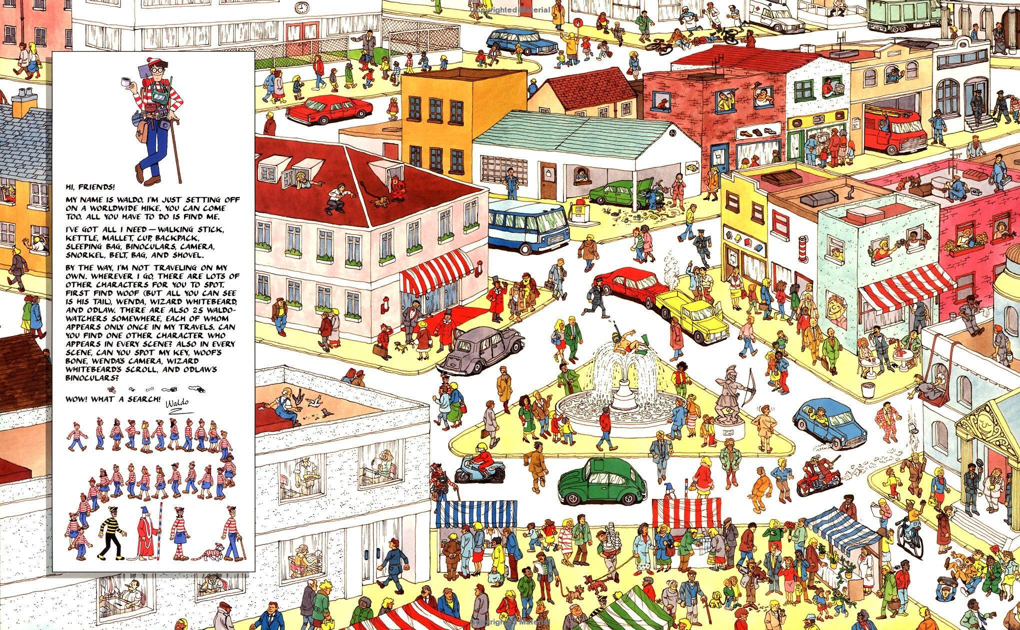

In [157]:
im = Image.open("./Data/images/"+'Wally_1.jpg')
im.resize((im.size[0]//2, im.size[1]//2))

The white area covers Waldo! It works!

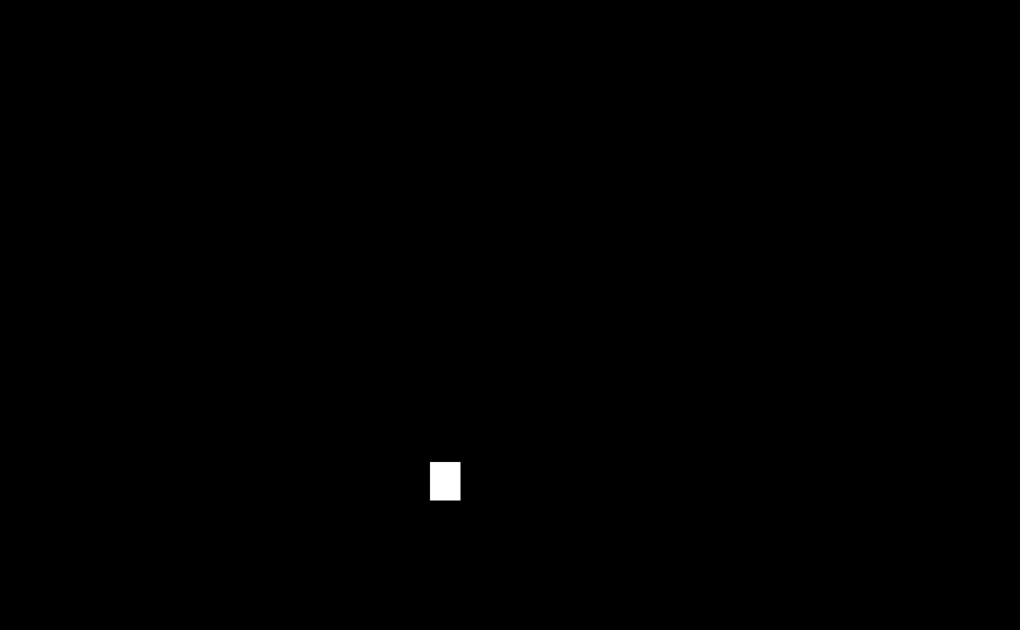

In [158]:
im = Image.open("./Data/targets/"+'Wally_1.png')
im.resize((im.size[0]//2, im.size[1]//2))

Now that we've built and saved our target images, we're going to load in a constant size, preprocess, and save the arrays.

In [159]:
def get_img_num(img_file):
    basename = os.path.basename(img_file)
    num_part = basename.split('_')[1].split('.')[0]
    return int(num_part)

img_files = sorted(glob.glob("./Data/images/*.jpg"), key=get_img_num)
trg_files = sorted(glob.glob("./Data/targets/*.png"), key=get_img_num)

I will use only high resolution images, because if I scale the image down, Waldo will be just a blob of pixels, making it very hard for the model to find him. 

In [160]:
img_sz = (2800, 1760)

def load_image(img, img_sz=None): 
    if img_sz:
        return np.array(Image.open(img).resize(img_sz, Image.NEAREST))
    else:
        return np.array(Image.open(img))
    
def load_label(img, img_sz): return np.array(Image.open(img).convert("L").resize(img_sz, Image.NEAREST))

imgs = np.stack([load_image(img_file, img_sz) for img_file in img_files])
labels = np.stack([load_label(trg_file, img_sz) for trg_file in trg_files])

In [161]:
len(imgs), len(labels)

(15, 15)

Now I have everything in one array. I'll normalize the value of each pixel for the images. This is a step in machine learning to standardize input data, so that they are on a similar scale.

In [162]:
imgs = imgs/255

labels = labels/255

mu = np.mean(imgs)

std = np.std(imgs)

imgs -= mu

imgs /=std

In [163]:
%%script false=

np.save('imgs.npy', imgs)
np.save('labels.npy', labels)

Couldn't find program: 'false='


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9002709780601945..1.2395395207331543].


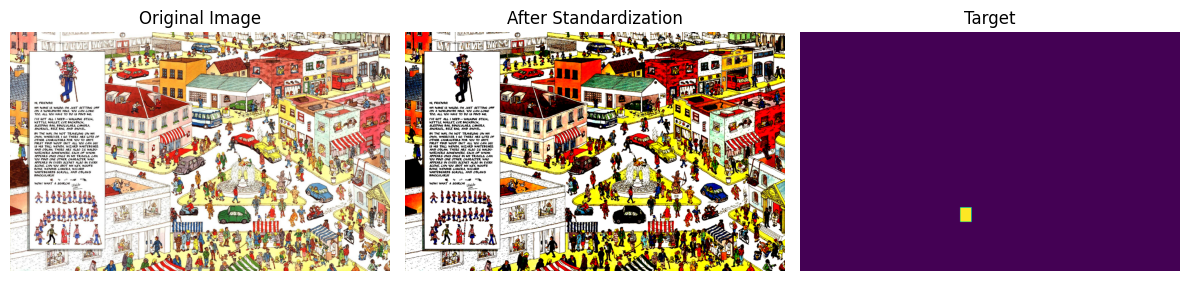

In [164]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

axes[0].imshow(imgs[0]*std + mu)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(imgs[0])
axes[1].set_title('After Standardization')
axes[1].axis('off')
axes[2].imshow(labels[0])
axes[2].set_title('Target')
axes[2].axis('off')

plt.tight_layout()
plt.show()

So now we've created targets for our images, however this data isn't much. Not even close to make the model good. So what we can do is make some subimages. Create smaller images by generating a random sample from these larger images with the correct label. I will create image sizes of 254x254, given that the image size is 2800x1760 we can easily generate so much data. Add horizontal flipping to double the amount. By using subimages and not the original image, the input is also smaller, making it easier for the machine to find Waldo.

Lets first focus on extracting Waldo. We could do it by hand, but letting the computer do the job is much better. We first zoom in on his box, then make the total size 254x254 pixels, and place him randomly in the grid (so the computer can learn he can be everywhere).

In [165]:
def extract_254_sub_image(img, label, box):
    wstart, wend, hstart, hend = box
    
    # Dimensions of the bounding box
    box_width = wend - wstart
    box_height = hend - hstart
    
    # Ensure the bounding box is within a 254x254 region
    assert box_width <= 254 and box_height <= 254, "Bounding box is larger than 254x254"

    # Calculate the possible ranges for random offsets
    max_h_offset = 254 - box_height
    max_w_offset = 254 - box_width
    
    # Generate random offsets
    h_offset = np.random.randint(0, max_h_offset + 1)
    w_offset = np.random.randint(0, max_w_offset + 1)
    
    # Calculate the starting and ending points for the 254x254 subimage
    sub_h_start = max(0, hstart - h_offset)
    sub_w_start = max(0, wstart - w_offset)
    sub_h_end = sub_h_start + 254
    sub_w_end = sub_w_start + 254
    
    # Adjust if the subimage size exceeds the image boundaries
    if sub_h_end > img.shape[0]:
        sub_h_end = img.shape[0]
        sub_h_start = sub_h_end - 254
    
    if sub_w_end > img.shape[1]:
        sub_w_end = img.shape[1]
        sub_w_start = sub_w_end - 254
    
    sub_img = img[sub_h_start:sub_h_end, sub_w_start:sub_w_end]
    sub_label = label[sub_h_start:sub_h_end, sub_w_start:sub_w_end]
    
    return sub_img, sub_label

def find_box(label):
    hstart, hend = None, None
    wstart, wend = None, None

    # Find vertical boundaries (rows)
    for i in range(label.shape[0]):
        if np.any(label[i, :]):
            if hstart is None:
                hstart = i
            hend = i + 1 

    # Find horizontal boundaries (columns)
    for j in range(label.shape[1]):
        if np.any(label[:, j]):
            if wstart is None:
                wstart = j
            wend = j + 1 

    return wstart, wend, hstart, hend

In [166]:
waldo_sub_imgs = []
waldo_sub_labels = []

for i, label in enumerate(labels):
    box = find_box(label)
    sub_img, sub_label = extract_254_sub_image(imgs[i], label, box)

    waldo_sub_imgs.append(sub_img)
    waldo_sub_labels.append(sub_label)

# Convert lists to numpy arrays
waldo_sub_imgs = np.array(waldo_sub_imgs)
waldo_sub_labels = np.array(waldo_sub_labels)

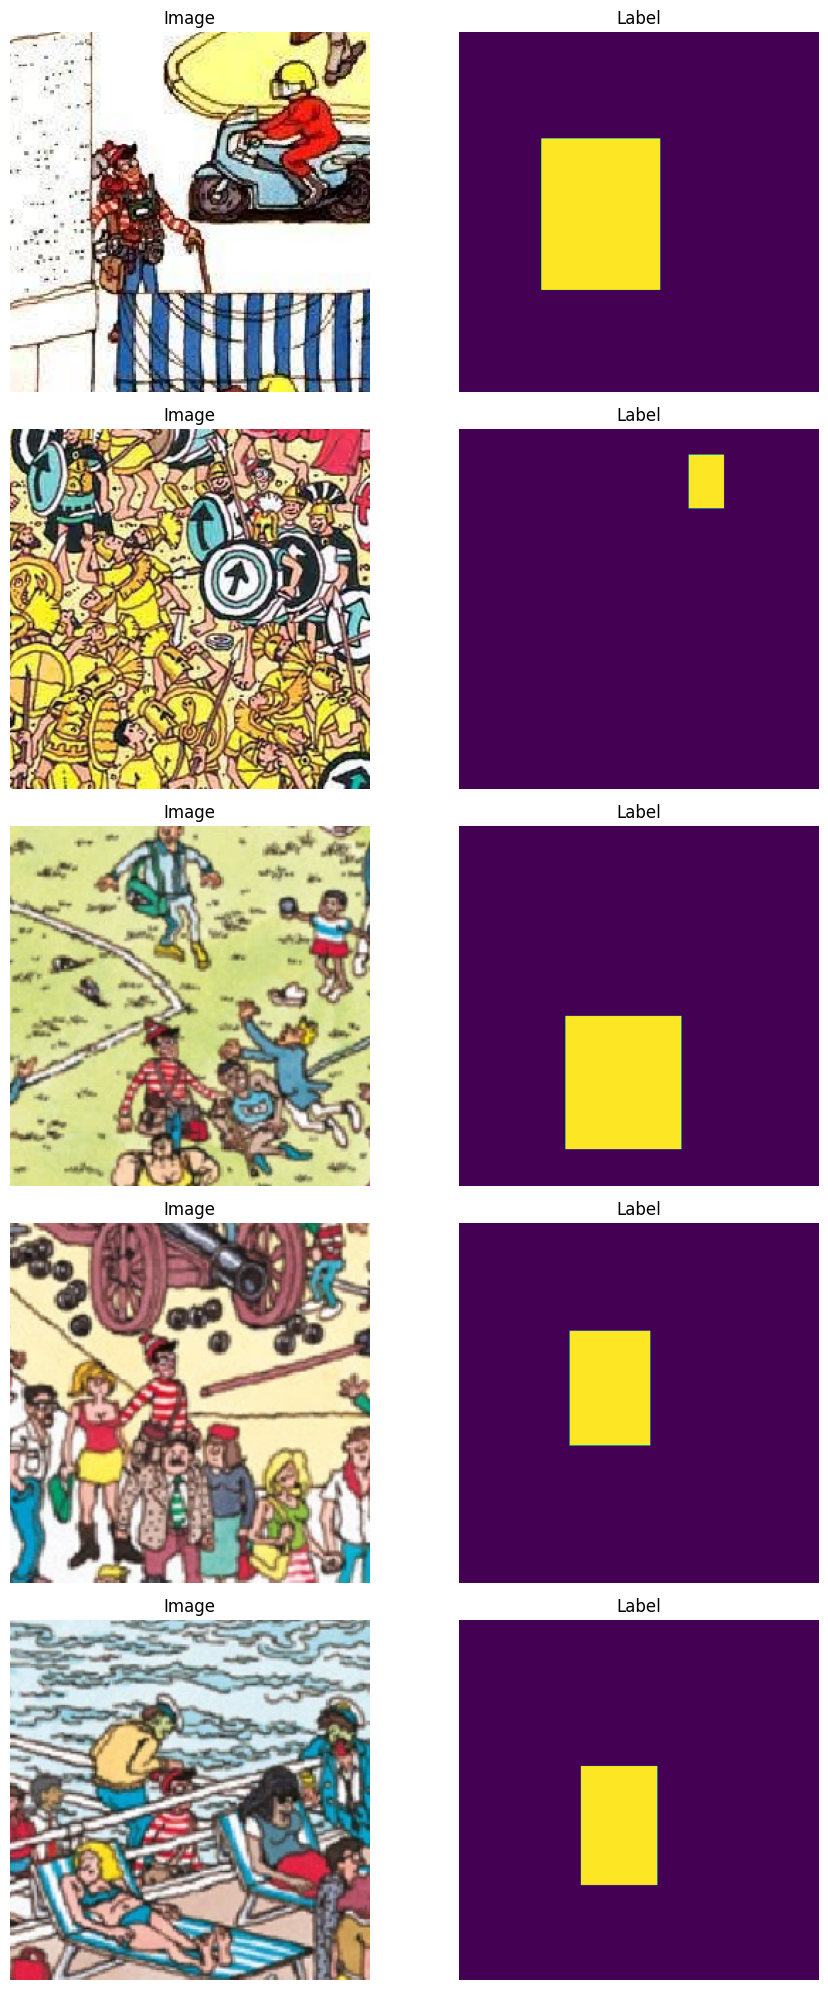

In [167]:
# Subplots for the first 5 images, side by side, .label and image
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    axes[i, 0].imshow(waldo_sub_imgs[i]*std+mu)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(waldo_sub_labels[i])
    axes[i, 1].set_title('Label')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

Great it works! After reviewing some pictures, I've decided to remove some, because they were to unsharp and added better ones.

In [168]:
%%script false

np.save('waldo_sub_imgs.npy', waldo_sub_imgs)
np.save('waldo_sub_labels.npy', waldo_sub_labels)

Couldn't find program: 'false'


This next piece is pretty complicated, it is about creating a smart system that helps to pick and mix small pieces of pictures (like tiny puzzle pieces) from larger images. This system is used to train a computer program to recognize certain objects in images.

* BatchIndices:
This part creates groups of numbers that act like addresses to different pieces of the pictures. It can shuffle these numbers to mix things up, ensuring a random selection.

* segm_generator:
This part uses the groups of numbers to actually pick out pieces of the pictures. It can pick these pieces in a random way or in order, and it can decide whether or not to include certain objects in the pieces it picks.

* seg_gen:
This part ensures the system works well with older versions of Python, a programming language.

* seg_gen_mix:
This part combines pieces from two different types of images: ones that contain a specific object (like Waldo) and ones that don’t. It mixes these pieces together in a specified proportion to create a balanced set for training.

Overall, this system helps to create diverse and balanced sets of image pieces, which are then used to teach a computer how to identify objects within pictures.

I didn't write this code myself, this is a editted version of iterators found in [Jeremy Howard's Tiramisu notebook](https://github.com/fastai/courses/blob/master/deeplearning2/tiramisu-keras.ipynb).

In [169]:
# import threading
import threading
from keras.utils import to_categorical


class BatchIndices(object):
    """
    Generates batches of shuffled indices.
    # Arguments
        n: number of indices
        bs: batch size
        shuffle: whether to shuffle indices, default False 
    
    """
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res
        
class segm_generator(object):
    """
    Generates batches of sub-images.
    # Arguments
        x: array of inputs
        y: array of targets
        bs: batch size
        out_sz: dimension of sub-image
        train: If true, will shuffle/randomize sub-images
        waldo: If true, allow sub-images to contain targets.
    """
    def __init__(self, x, y, bs=64, out_sz=(224, 224), train=True, waldo=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.waldo = waldo
        self.n = x.shape[0]
        self.ri, self.ci = [], []
        for i in range(self.n):
            ri, ci, _ = x[i].shape
            self.ri.append(ri), self.ci.append(ci) 
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = np.random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri[idx], self.ro)
        slice_c = self.get_slice(self.ci[idx], self.co)
        x = self.x[idx][slice_r, slice_c]
        y = self.y[idx][slice_r, slice_c]
        if self.train and (np.random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        if not self.waldo and np.sum(y)!=0:
            return None
        return x, to_categorical(y, num_classes=2)

    def __next__(self):
        idxs = self.idx_gen.__next__()
        items = []
        for idx in idxs:
            item = self.get_item(idx)
            if item is not None:
                items.append(item)
        if not items:
            return None
        xs,ys = zip(*tuple(items))
        return np.stack(xs), np.stack(ys)
    
def seg_gen(x, y, bs=64, out_sz=(224, 224), train=True, waldo=True):
    """
    Generator wrapper on iterators for python 2 compatibility.
    """
    sg = segm_generator(x=x, y=y, bs=bs, out_sz = out_sz ,train=train, waldo=waldo)
    while True:
        yield sg.__next__()

def seg_gen_mix(x1, y1, x2, y2, tot_bs=4, prop=0.75, out_sz=(224,224), train=True):
    """
    Mixes generator output. The second generator is set to skip images that contain any positive targets.
    # Arguments
        x1, y1: input/targets for waldo sub-images
        x2, y2: input/targets for whole images
        tot_bs: total batch size
        prop: proportion of total batch size consisting of first generator output
    """
    n1 = int(tot_bs*prop)
    n2 = tot_bs - n1
    sg1 = segm_generator(x1, y1, n1, out_sz = out_sz ,train=train)
    sg2 = segm_generator(x2, y2, n2, out_sz = out_sz ,train=train, waldo=False)
    while True:
        out1 = sg1.__next__()
        out2 = sg2.__next__()
        if out2 is None:
            yield out1
        else:
            yield np.concatenate((out1[0], out2[0])), np.concatenate((out1[1], out2[1]))

We have to use one-hot encoding, so I'll reshape the data into one vector.

In [170]:
def data_generator_with_reshape(gen_mix):
    for X_batch, y_batch in gen_mix:
        y_batch = y_batch.reshape((y_batch.shape[0], -1, 2))
        yield X_batch, y_batch

In [171]:
gen_mix = seg_gen_mix(waldo_sub_imgs, waldo_sub_labels, imgs, labels)
gen_mix = data_generator_with_reshape(gen_mix)

X, y = next(gen_mix)

In [172]:
# Verify the shapes
for X_batch, y_batch in gen_mix:
    print(f"X_batch.shape: {X_batch.shape}, y_batch.shape: {y_batch.shape}")
    break

X_batch.shape: (4, 224, 224, 3), y_batch.shape: (4, 50176, 2)


We'll combine the area of the picture 224*224 into one long array. This way it's easier for the model to understand it.

In [173]:
y = y.reshape(4, 50176, 2)
X.shape, y.shape

((4, 224, 224, 3), (4, 50176, 2))

Alright let's test some images out.

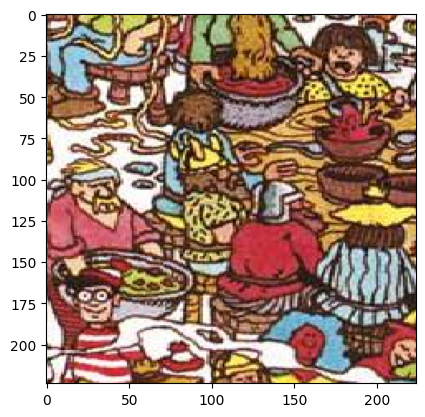

In [174]:
plt.imshow(X[0]*std+mu)

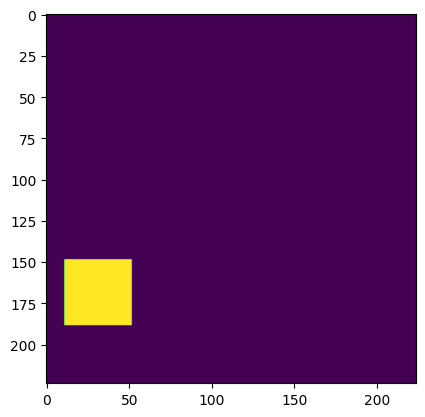

In [175]:
plt.imshow(y[0].reshape(224, 224, 2)[:,:,1])

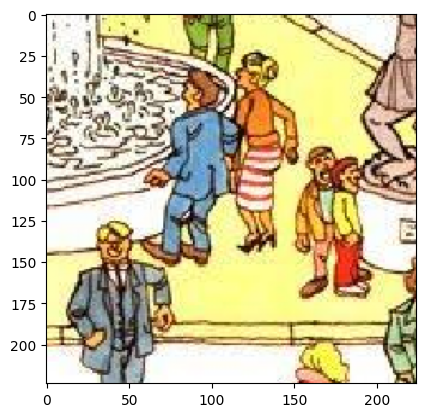

In [176]:
plt.imshow(X[-1]*std+mu)

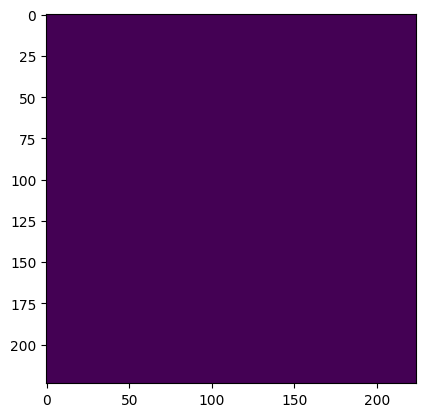

In [177]:
plt.imshow(y[-1].reshape(224, 224, 2)[:,:,1])

## Model

Now we are ready for the modelling part, first check the frequency of Waldo and Non-Waldo.

In [178]:
freq0 = float(np.sum(labels==0))
freq1 = float(np.sum(labels==1))

freq0, freq1

(73867077.0, 52923.0)

In [179]:
class_weights = {0:1/freq0, 1:1.}

sample_weights = np.zeros((X.shape[0], X.shape[1] * X.shape[2], 2))

sample_weights.shape

sample_weights[:,:,0] = class_weights[0]

sample_weights[:,:,1] = class_weights[1]

In [180]:
class_weights, sample_weights

({0: 1.3537830933800182e-08, 1: 1.0},
 array([[[1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00],
         ...,
         [1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00]],
 
        [[1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00],
         ...,
         [1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00]],
 
        [[1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00],
         ...,
         [1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00]],
 
        [[1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00],
         [1.35378309e-08, 1.00000000e+00],
        

Here we create our neural network.

In [181]:
import keras
from tiramisu import *

input_shape = (224,224,3)

img_input = keras.Input(shape=input_shape)
x = create_tiramisu(2, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)
model = Model(img_input, x)

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

x shape (None, 14, 14, 240) skip shape (None, 14, 14, 656)
x shape (None, 28, 28, 192) skip shape (None, 28, 28, 464)
x shape (None, 56, 56, 160) skip shape (None, 56, 56, 304)
x shape (None, 112, 112, 112) skip shape (None, 112, 112, 192)
x shape (None, 224, 224, 80) skip shape (None, 224, 224, 112)


In [182]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, y, sample_weights))

In [190]:
from tqdm.keras import TqdmCallback

model.fit(gen_mix, steps_per_epoch=5, epochs=1000, verbose=0, callbacks=[TqdmCallback()])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

KeyboardInterrupt: 

In [185]:
h = model.history.history

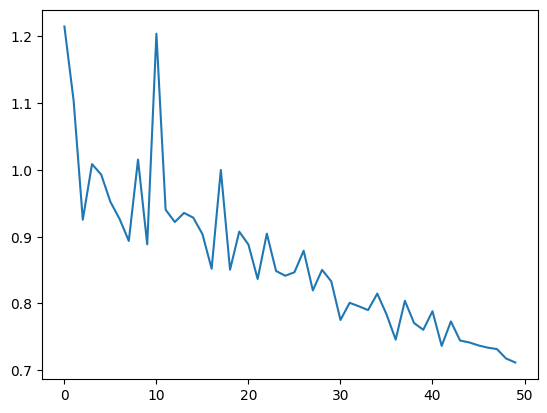

In [186]:
plt.plot(h['loss'], label='loss')

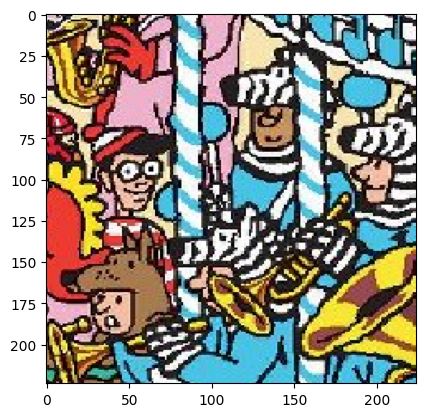

In [187]:
plt.imshow(X[1]*std+mu)

In [188]:
pred = model.predict_on_batch(X)

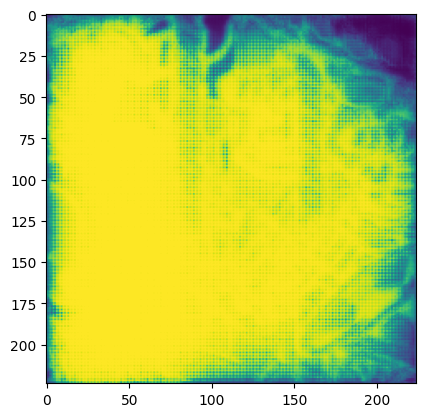

In [189]:
plt.imshow(pred[1].reshape(224, 224, 2)[:,:,1])